# 1. Setup and load data

Link to the data: https://drive.google.com/drive/folders/1h7Sok5y7nGcFg3j-qC196VcUtMgbCCLd?usp=sharing

## 1.1 Install dependencies and setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
import imghdr
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, SpatialDropout2D
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

! pip install shap
import shap

from keras import layers
import keras

In [ ]:
# Check wether we have access to GPU
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth, this prevents Colab from using our entire RAM when working.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Load our data

In [ ]:
# path to the folder containing our ornithischian images and theropod images
data_dir='/content/drive/MyDrive/ML_ENV/rsif-2022-0588-File007/dataset'

In [ ]:
# Checking that our folder contains both classes
for image_class in os.listdir(data_dir):
  print(image_class)

In [ ]:
# build the dataset
# we'll be using batches of 32 which nicely divides 1216 images
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size = (100,100), batch_size = 32)

In [ ]:
# converts our images to numpy arrays for us to easily loop through the data
data_iterator = data.as_numpy_iterator()

In [ ]:
# this allows to get another batch from our iterator
batch = data_iterator.next()

In [ ]:
# shape of a batch of images in numpy array
batch[0].shape

In [ ]:
# have a look at the labels of a batch
batch[1]

In [ ]:
# have a look at our images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
class_labels = os.listdir(data_dir)  # Define the class labels

for idx, img in enumerate(batch[0][:4]):
    label_index = batch[1][idx]
    class_name = class_labels[label_index]

    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_name)

# labels '0' will correspond to 'ornithischian' and labels '1' to 'theropod'

## 2.Data Preprocessing

### 2.1 Balancing our Data to have as many ornithischian images as theropod images

In [ ]:
# reload the dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size = (100,100))

### 2.2 Undersampling our data, so both classes will match in length

In [ ]:
class_indices = [0, 1]

# Extract labels and features from the dataset
labels = []
features = []

for batch in data:
    features.append(batch[0])
    labels.append(batch[1])

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Reshape the labels to a 1D array
labels = labels.reshape(-1, 1)

# Count the number of samples in each class
class_counts = [np.sum(labels == i) for i in class_indices]

# Calculate the desired number of samples for undersampling
desired_samples = min(class_counts)

# Calculate the undersampling ratios
sampling_ratios = {class_indices[i]: desired_samples for i in range(len(class_indices))}

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=sampling_ratios, random_state=42)

# Resample the data
resampled_features, resampled_labels = rus.fit_resample(features.reshape(-1, 100 * 100 * 3), labels)

# Reshape the data back to the original shape
resampled_features = resampled_features.reshape(-1, 100, 100, 3)

# Convert labels back to 1D array
resampled_labels = resampled_labels.flatten()

# Create a new tf.data.Dataset for features and labels
resampled_data = tf.data.Dataset.from_tensor_slices((resampled_features, resampled_labels))
resampled_data = resampled_data.shuffle(buffer_size=len(resampled_labels)).batch(32)

In [ ]:
# having a look at our imbalanced data
for i, count in enumerate(class_counts):
    print(f"Class {class_indices[i]}: {count} images")

In [ ]:
# Count the number of samples in each class after undersampling
resampled_class_counts = [np.sum(resampled_labels == i) for i in class_indices]

# Print the number of images for each class
for i, count in enumerate(resampled_class_counts):
    print(f"Class {class_indices[i]}: {count} images")

### 2.2 Scale Data

In [ ]:
# scale our data to have min and max pixel values of 0 and 1 instead of 0 and 255
scaled_data = resampled_data.map(lambda x,y: (x/255, y))

In [ ]:
# get access to our data again
scaled_iterator=scaled_data.as_numpy_iterator()
# grabbing next batch
batch=scaled_iterator.next()
# to make sur we have succesfully rescaled our data
print('Min value: ',batch[0].min(),'\nMax value: ',batch[0].max())

In [ ]:
#what does our batch[0] look like now
batch[0].shape

In [ ]:
images = batch[0]
labels = batch[1]

# Separate images based on labels
images_label_0 = images[labels == 0]
images_label_1 = images[labels == 1]

# Print the shape of the separated sets of images
print("Images with label 0 shape:", images_label_0.shape)
print("Images with label 1 shape:", images_label_1.shape)

### 2.3 Split our data

In [ ]:
# Have a look at our total number of batches
print('We have ',len(scaled_data),'batches of ',batch[0].shape[0],'images.\nFor a total of ',batch[0].shape[0]*len(scaled_data),'images.')

In [ ]:
# assign sizes to each set of data
train_size = int(len(scaled_data)*.8)
val_size = int(len(scaled_data)*.1)
test_size = int(len(scaled_data)*.1)
print('train_size: ',train_size,'batches of ',batch[0].shape[0],'images, for a total of ',batch[0].shape[0]*train_size,'images.',
      '\nval_size: ',val_size,'batches of ',batch[0].shape[0],'images, for a total of ',batch[0].shape[0]*val_size,'images.',
      '\ntest_size: ',test_size,'batches of ',batch[0].shape[0],'images, for a total of ',batch[0].shape[0]*test_size,'images.')

In [ ]:
#  split the data
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

## 4. The CNN model

### 4.1 Build the CNN architecture

In [ ]:
# Let's clear out the backend and set our random seeds
# Consistency makes things easier for labs!
#keras.backend.clear_session()
rnd_seed=42
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

In [ ]:
# Lets have a look at an image to make sure everything goes smoothly with our data dimensions
for images, labels in train.take(1):
  print(f'Images shape: {images.numpy().shape} Labels: {labels.numpy().shape}')
  print(f'Max pixel value: {images.numpy().max()}, min pixel value: {images.numpy().min()}')
  print("Here's a sample image:\n")
  fig,ax = plt.subplots()
  ax.axis('off')
  ax.imshow(images[0])

In [ ]:
# We'll be performing data augmentation, so let's build it
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=(-30, 30), fill_mode="nearest"),
    layers.RandomFlip(mode="horizontal_and_vertical")
])

In [ ]:
# add a dropout so our model does not rely too heavily on certain neurons
dropout = 0.1
# store our model
model = Sequential()
# add augmentation
model.add(data_augmentation)
# add our layers
model.add(Conv2D(8, (3,3), 1, activation='relu', input_shape=(100,100,3)))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(dropout))
# model.add(data_augmentation)

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(dropout))
# model.add(data_augmentation)

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(dropout))
# model.add(data_augmentation)

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(SpatialDropout2D(dropout))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # DONE replaced softmax with sigmoid

In [ ]:
# compile our model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None, 100, 100, 3))

In [ ]:
model.summary()

### 3.2 Train the model

In [ ]:
# build our checkpoint to save our best models in regards to validation loss
from keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Colab Notebooks/best_model/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


In [ ]:
# fitting our model
hist = model.fit(train, epochs=200, validation_data=val, callbacks = [checkpoint, earlystop])

Epoch 1/200
29/30 [============================>.] - ETA: 0s - loss: 0.6805 - accuracy: 0.5722
Epoch 1: val_loss improved from inf to 0.59118, saving model to /content/drive/MyDrive/Colab Notebooks/best_model/my_best_model.epoch01-loss0.59.hdf5


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


30/30 [==============================] - 14s 52ms/step - loss: 0.6840 - accuracy: 0.5698 - val_loss: 0.5912 - val_accuracy: 0.6979
Epoch 2/200
28/30 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.5893
Epoch 2: val_loss did not improve from 0.59118
30/30 [==============================] - 1s 32ms/step - loss: 0.6557 - accuracy: 0.5906 - val_loss: 0.6171 - val_accuracy: 0.6562
Epoch 3/200
29/30 [============================>.] - ETA: 0s - loss: 0.6046 - accuracy: 0.6573
Epoch 3: val_loss improved from 0.59118 to 0.58994, saving model to /content/drive/MyDrive/Colab Notebooks/best_model/my_best_model.epoch03-loss0.59.hdf5
30/30 [==============================] - 1s 26ms/step - loss: 0.6048 - accuracy: 0.6562 - val_loss: 0.5899 - val_accuracy: 0.6562
Epoch 4/200
30/30 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.6865
Epoch 4: val_loss did not improve from 0.58994
30/30 [==============================] - 1s 26ms/step - loss: 0.5980 - accur

## 4. Results

### 4.1 Plot performance

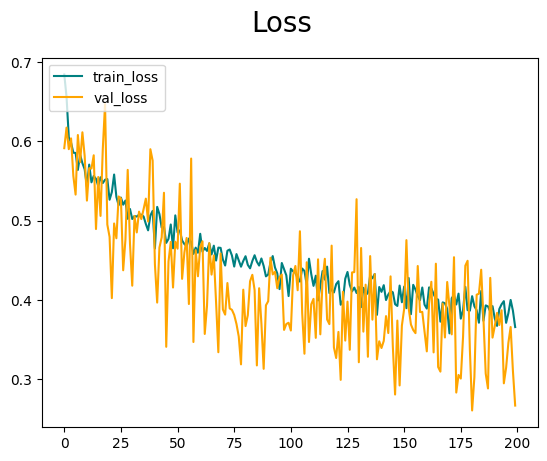

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss') # changed the label for clarity
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

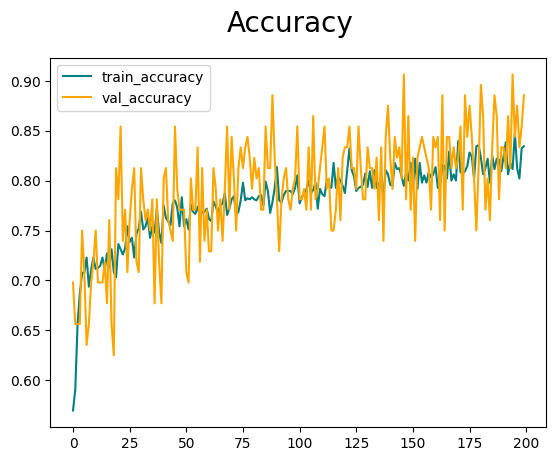

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train_accuracy') # Changed the label for clarity
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4.2 Evaluation

In [ ]:
# load our best model
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model/my_best_model.epoch194-loss0.28.hdf5')

In [ ]:
# Access validation accuracy and loss from the history object
validation_accuracy = hist.history['val_accuracy']
validation_loss = hist.history['val_loss']

# Find the index of the epoch with the lowest validation loss
best_epoch = np.argmin(validation_loss)

# Get the corresponding validation accuracy for the best epoch
best_val_accuracy = validation_accuracy[best_epoch]

# Print the validation accuracy for the epoch with the best validation loss
print("Validation Accuracy at Best Validation Loss:", best_val_accuracy)

Validation Accuracy at Best Validation Loss: 0.8958333134651184


In [ ]:
# We will evaluate our model on the test set
# Creating empty X and y lists for our images and labels
X = []
y = []

# Iterate through the unbatched dataset
for image, label in test.unbatch():
    # Process each image and label here
    X.append(image.numpy())  # Append the image to X
    y.append(label.numpy())  # Append the label to y

# Convert lists to NumPy arrays if needed
X = np.array(X)
yield_flat_up_to = np.array(y)

# Check the length of X and Y
print("Length of X:", len(X))
print("Length of y:", len(y))

Length of X: 96
Length of y: 96


In [ ]:
# Evaluate the model on the test set
X_test = np.array(X)
y_test = np.array(y)

evaluation_result = model.evaluate(X_test, y_test)



# Print the evaluation result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

3/3 [==============================] - 0s 17ms/step - loss: 0.3781 - accuracy: 0.8333
Test Loss: 0.3780672252178192
Test Accuracy: 0.8333333134651184


### 4.3 Plot our results for a few images

3/3 [==============================] - 0s 5ms/step


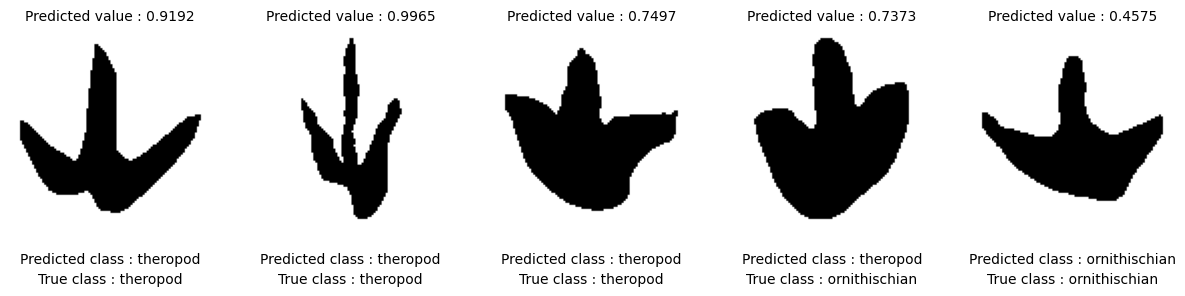

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# let's store the prediction values in a variable
predictions = best_model.predict(X_test)

# here we generate random indices of our images, to randomly display a set of images
random_indices = np.random.choice(len(X_test), size=5, replace=False)

# Create subplots for our images
fig, axes = plt.subplots(1, len(random_indices), figsize=(15, 6))

# Dictionary to match the class name with its label
class_mapping = {0: "ornithischian", 1: "theropod"}

for i, indice_image in enumerate(random_indices):
    # get image, prediction and true class associated with it
    image = X_test[indice_image]
    prediction = predictions[indice_image]
    true_class = class_mapping[int(y_test[indice_image])]

    # get predicted class in function of predicted value
    predicted_class = "ornithischian" if prediction < 0.5 else "theropod"

    # Show image with predicted values
    axes[i].imshow(image)
    axes[i].set_title("Predicted value : {:.4f}".format(np.max(prediction)), fontsize=10)

    # Show predicted class of image
    axes[i].text(0.5, -0.15, "Predicted class : {}".format(predicted_class), ha="center", va="center", transform=axes[i].transAxes, fontsize=10)

    # Show true class of image
    axes[i].text(0.5, -0.25, "True class : {}".format(true_class), ha="center", va="center", transform=axes[i].transAxes, fontsize=10)

    axes[i].axis('off')

plt.show()

### 4.4 What about our ambiguous predicted values (between 0.4 and 0.6)?

In [ ]:
# The true labels for our test set
true_labels = y_test

# Counter for predictions between 0.4 and 0.6
between_04_06_count = 0

# Counter for correct predictions between 0.4 and 0.6
correct_between_04_06_count = 0

# Counter for predictions outside the range 0.4 to 0.6
outside_04_06_count = 0

# Counter for correct predictions outside the range 0.4 to 0.6
correct_outside_04_06_count = 0

for i in range(len(predictions)):
    # Check if the predicted value is between 0.4 and 0.6
    if 0.4 <= predictions[i] <= 0.6:
        between_04_06_count += 1

        # Check if the prediction is correct
        if predictions[i] >= 0.5 and true_labels[i] == 1:
            correct_between_04_06_count += 1
        elif predictions[i] < 0.5 and true_labels[i] == 0:
            correct_between_04_06_count += 1
    else:
        outside_04_06_count += 1

        # Check if the prediction is correct
        if predictions[i] >= 0.5 and true_labels[i] == 1:
            correct_outside_04_06_count += 1
        elif predictions[i] < 0.5 and true_labels[i] == 0:
            correct_outside_04_06_count += 1

# Calculate the proportion of predictions between 0.4 and 0.6
proportion_between_04_06 = between_04_06_count / len(predictions)
print("Proportion of ambiguous predictions:", proportion_between_04_06)

# Check if there are predictions between 0.4 and 0.6 before calculating the proportion of correct predictions
if between_04_06_count > 0:
    # Calculate the proportion of correct predictions among values between 0.4 and 0.6
    proportion_correct_between_04_06 = correct_between_04_06_count / between_04_06_count
    print("Proportion of correct ambiguous predictions:", proportion_correct_between_04_06)
else:
    print("No predictions between 0.4 and 0.6 in the test set.")

# Calculate the proportion of predictions outside the range 0.4 to 0.6
proportion_outside_04_06 = outside_04_06_count / len(predictions)
print("\nProportion of predictions outside 0.4 and 0.6:", proportion_outside_04_06)

# Check if there are predictions outside the range 0.4 and 0.6 before calculating the proportion of correct predictions
if outside_04_06_count > 0:
    # Calculate the proportion of correct predictions among values outside 0.4 and 0.6
    proportion_correct_outside_04_06 = correct_outside_04_06_count / outside_04_06_count
    print("Proportion of correct predictions outside 0.4 and 0.6:", proportion_correct_outside_04_06)
else:
    print("No predictions outside 0.4 and 0.6 in the test set.")


Proportion of ambiguous predictions: 0.08333333333333333
Proportion of correct ambiguous predictions: 0.5

Proportion of predictions outside 0.4 and 0.6: 0.9166666666666666
Proportion of correct predictions outside 0.4 and 0.6: 0.8295454545454546


## 4.5 What class is it more incertain about?

In [ ]:
between_04_05_count=0
between_05_06_count=0
for i in range(len(predictions)):
    # Check if the predicted value is between 0.4 and 0.6
    if 0.4 <= predictions[i] <= 0.5:
        between_04_05_count += 1
for i in range(len(predictions)):
    # Check if the predicted value is between 0.4 and 0.6
    if 0.5 <= predictions[i] <= 0.6:
        between_05_06_count += 1
print('<0.5: ',between_04_05_count,'\n>0.5: ',between_05_06_count)

<0.5:  6 
>0.5:  2


### 4.5 Compute confusion matrix and scores for our best model

3/3 [==============================] - 0s 5ms/step
Accuracy: 0.8020833333333334
F1 Score: 0.7912087912087913
Recall: 0.8571428571428571


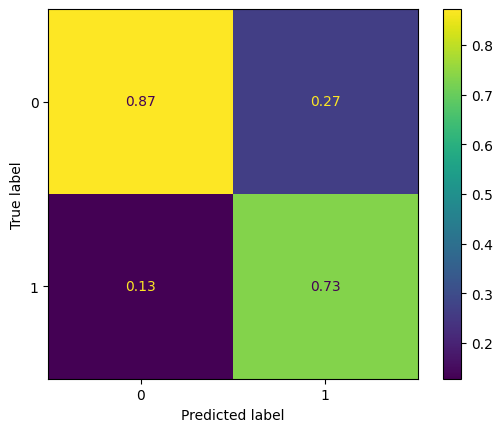

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,recall_score

# Assuming predictions is the output of your model on X_test
my_predictions = best_model.predict(X_test)

# Convert predicted probabilities to binary predictions (0 or 1)
binary_predictions = (predictions >= 0.5).astype(int)

# Assuming y_test is the true labels for your test set
true_labels = y_test

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, binary_predictions, normalize='pred')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Calculate and print the accuracy
accuracy = accuracy_score(true_labels, binary_predictions)
print("Accuracy:", accuracy)

# Calculate and print the F1 score
f1 = f1_score(true_labels, binary_predictions)
print("F1 Score:", f1)

# Calculate and print the recall
recall = recall_score(true_labels, binary_predictions)
print("Recall:", recall)

##5. Lallensack's model

### 5.1 Import his model

In [ ]:
import h5py
import glob
import cv2
from keras.models import load_model
# path to his model
Lallensack = load_model('/content/drive/MyDrive/ML_ENV/DinoTracks_code/tridactyl_tracks_nn_v1.h5')

### 5.2 Preprocess the data for Lallensack's model

In [ ]:
# resample our data so it works with Lallensack's model, which only accepts 1 channel for color (grayscale). We had RGB, kinda unnecessary but oh well.

# Extract labels and features from the dataset
labels = []
features = []

for batch in scaled_data:
    features.append(batch[0])
    labels.append(batch[1])

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Convert images to grayscale
features_gray = tf.image.rgb_to_grayscale(features)

# Reshape the labels to a 1D array
labels = labels.reshape(-1, 1)

# Count the number of samples in each class
class_counts = [np.sum(labels == i) for i in class_indices]

# Calculate the desired number of samples for undersampling
desired_samples = min(class_counts)

# Calculate the undersampling ratios
sampling_ratios = {class_indices[i]: desired_samples for i in range(len(class_indices))}

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=sampling_ratios, random_state=42)

# Resample the data
resampled_features, resampled_labels = rus.fit_resample(features_gray.numpy().reshape(-1, 100 * 100), labels)

# Reshape the data back to the original shape
resampled_features = resampled_features.reshape(-1, 100, 100, 1)  # Change to (100, 100, 1) for grayscale

# Convert labels back to 1D array
resampled_labels = resampled_labels.flatten()

# Split the data into train, test, and validation sets
X_train_L, X_temp_L, y_train_L, y_temp_L = train_test_split(resampled_features, resampled_labels, test_size=0.4, random_state=42)
X_val_L, X_test_L, y_val_L, y_test_L = train_test_split(X_temp_L, y_temp_L, test_size=0.5, random_state=42)

# Create tf.data.Dataset for train, val, and test sets
train_data_L = tf.data.Dataset.from_tensor_slices((X_train_L, y_train_L)).shuffle(buffer_size=len(y_train_L)).batch(30)
val_data_L = tf.data.Dataset.from_tensor_slices((X_val_L, y_val_L)).batch(30)
test_data_L = tf.data.Dataset.from_tensor_slices((X_test_L, y_test_L)).batch(30)

### 5.3 Compute confusion matrix and scores for Lallensack's model

8/8 [==============================] - 0s 4ms/step
Accuracy: 0.8729508196721312
F1 Score: 0.8764940239043825
Recall: 0.9166666666666666


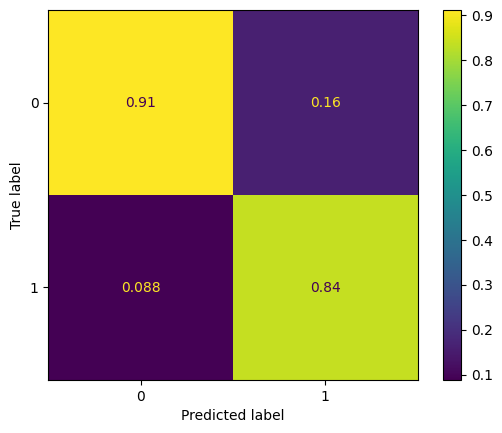

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,recall_score

# Assuming predictions is the output of your model on X_test
L_predictions = Lallensack.predict(X_test_L)

# Convert predicted probabilities to binary predictions (0 or 1)
L_binary_predictions = (L_predictions >= 0.5).astype(int)

# Assuming y_test is the true labels for your test set
true_labels = y_test_L

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, L_binary_predictions, normalize='pred')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Calculate and print the accuracy
accuracy = accuracy_score(true_labels, L_binary_predictions)
print("Accuracy:", accuracy)

# Calculate and print the F1 score
f1 = f1_score(true_labels, L_binary_predictions)
print("F1 Score:", f1)

# Calculate and print the recall
recall = recall_score(true_labels, L_binary_predictions)
print("Recall:", recall)

### 6. Apply SHAP DeepExplainer

In [ ]:
# Specify the correct path to your dataset directory
data_dir = '/content/drive/MyDrive/ML_ENV/rsif-2022-0588-File007/dataset'

# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(100, 100),
    batch_size=32,
    shuffle=False,
)

# Separate the dataset into two classes
orni = data.filter(lambda x, y: tf.math.equal(y, 0)[0])  # Assuming "ornithischian" has label 0
thero = data.filter(lambda x, y: tf.math.equal(y, 1)[0])  # Assuming "theropod" has label 1

# Print the number of samples in each class
print("Number of samples in class 'ornithischian':", len(list(orni)))
print("Number of samples in class 'theropod':", len(list(thero)))

Found 1587 files belonging to 2 classes.
Number of samples in class 'ornithischian': 19
Number of samples in class 'theropod': 31


In [ ]:
# Prepare our dat for the ornithischian (0) and theropod (1)
orni_iterator=orni.as_numpy_iterator()
thero_iterator=thero.as_numpy_iterator()

1/1 [==============================] - 0s 21ms/step


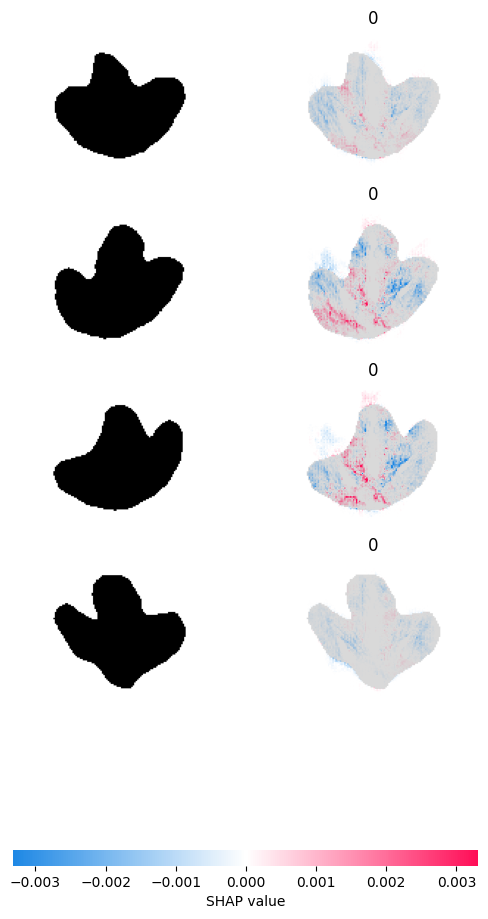

[[0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# # Extract ornithischian background ("Neutral") data and a few test images for interpretation
batch = next(orni_iterator)
images = batch[0]
lbls = batch[1]

lbls = lbls.reshape(lbls.shape[0], 1)

background = images[0:28]
test_images = images[28:32]
test_lbls = lbls[28:32]

my_predictions=best_model.predict(test_images)
tol = 0.05

# Initialize a DeepExplainer using the SHAP library and the pre-trained model
e = shap.DeepExplainer(best_model, background)


# Compute SHAP values for the test images
shap_values = e.shap_values(test_images)

# Plot the feature attributions using SHAP's image_plot function
shap.image_plot(shap_values, test_images,labels=test_lbls)
print(my_predictions)

1/1 [==============================] - 0s 106ms/step


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


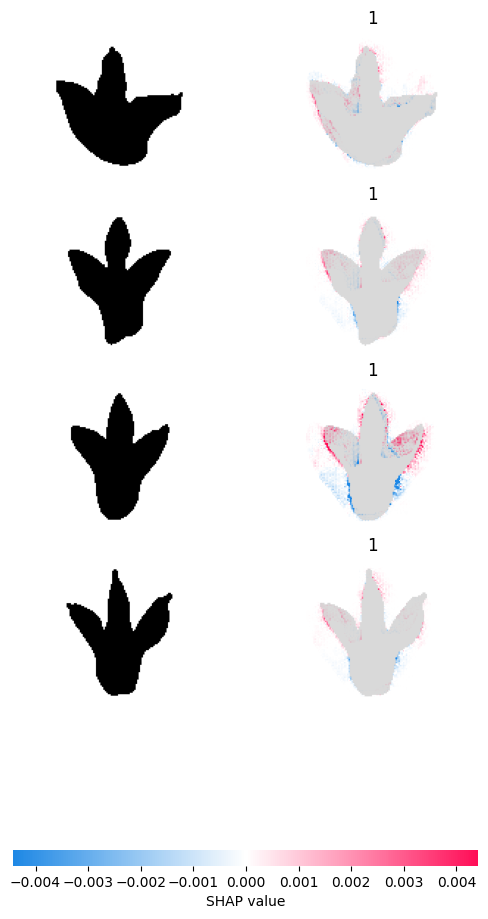

[[0.9999939 ]
 [1.        ]
 [1.        ]
 [0.99998677]]


In [ ]:
# # Extract ornithischian background ("Neutral") data and a few test images for interpretation
batch = thero_iterator.next()
images = batch[0]
lbls = batch[1]

lbls = lbls.reshape(lbls.shape[0], 1)

background = images[0:28]
test_images = images[28:32]

test_lbls = lbls[28:32]

my_predictions=model.predict(test_images)
tol = 0.02

# Initialize a DeepExplainer using the SHAP library and the pre-trained model
e = shap.DeepExplainer(best_model, background)


# Compute SHAP values for the test images
shap_values = e.shap_values(test_images)

# Plot the feature attributions using SHAP's image_plot function
shap.image_plot(shap_values, test_images,labels=test_lbls)
print(my_predictions)